In [123]:
import novosparc
import time
import numpy as np
import pandas as pd
import anndata as ad
import scanpy as sc
import random
import pickle
import os
from scipy.spatial.distance import cdist
from scipy.stats import pearsonr

# 1. Set the data and output paths

In [137]:
print("reading in data paths and parameter")

# TNBC
# data_dir = 'data'
# dataset_path = os.path.join(data_dir, 'TNBC_sn_integrated_dge.zip')  # use pickle to load
# target_space_path = os.path.join(data_dir, 'TNBC_6w_fc51_4_coordinates.csv')  # location coordinates
# atlas_path = os.path.join(data_dir, 'TNBC_atlas_OvrlbAtlasMarkerSnGenes.zip') # use pickle to load
# output_folder = os.path.join(data_dir, 'output')  # folder to save the results, plots etc.

# MouseBrain
data_dir = 'data_mouse'
dataset_path = os.path.join(data_dir, '10x_MouseBrain_dge.csv')
target_space_path = os.path.join(data_dir, '10x_MouseBrain_coordinates.csv')  # location coordinates
atlas_path = os.path.join(data_dir, 'mouse_brain_test_atlas.csv')
output_folder = os.path.join(data_dir, 'output')  # folder to save the results, plots etc.


# 1.1. set subsample parameter when used
min_num_cells = 500
max_num_cells = 1000

n_loc_atlas = 500

# for linear assumption
marker_subset = 5
alpha_parameter = 0.8

# for neighbor assumption
num_neighbors_s = 5
num_neighbors_t = 5

reading in data paths and parameter


# 2. Read the dataset and subsample

In [140]:
# TNBC
# print("Reading in dge")
# dataset_rdn = pd.read_pickle(dataset_path)
# print("convert dge to anndata")
# dataset = ad.AnnData(dataset_rdn)

# Mouse
dataset = sc.read(dataset_path).T

gene_names = dataset.var.index.tolist()
num_cells, num_genes = dataset.shape
print('number of cells total: %d' % num_cells)
print('number of genes: %d' % num_genes)

# Optional: downsample number of cells.
print("Downsampling number of cells")
cells_selected, dataset = novosparc.pp.subsample_dataset(dataset,
                                                         min_num_cells=min_num_cells,
                                                         max_num_cells=max_num_cells)

num_cells, num_genes = dataset.shape
print('number of cells used: %d' % num_cells)

# Load the location coordinates from file if it exists
print("Reading in locations")
locations = pd.read_csv(target_space_path, sep=',')
num_locations = locations.shape[0]  # coming from the spatial data #
locations_apriori = locations[:num_locations][['xcoord', 'ycoord']].values
locations = locations_apriori

# Read the atlas
print("Reading in atlas")
# TNBC
# atlas_rdn = pd.read_pickle(atlas_path)
# atlas = ad.AnnData(atlas_rdn)

# Mouse
chunks = pd.read_csv(atlas_path, index_col=0, chunksize=1000000)
df = pd.concat(chunks)
atlas = sc.AnnData(df)

atlas_genes = atlas.var.index.tolist()
atlas.obsm['spatial'] = locations

print('number of locations total: %d' % len(locations))

# Optional: downsample the number of locations
print("Downsampling atlas")
sc.pp.subsample(atlas, n_obs=n_loc_atlas)
locations = atlas.obsm['spatial']
locations_apriori = locations
atlas_genes = atlas.var.index.tolist()
print('number of locations used: %d' % len(locations_apriori))

number of cells total: 2688
number of genes: 18078
Downsampling number of cells
number of cells used: 710
Reading in locations
Reading in atlas
number of locations total: 2688
Downsampling atlas
number of locations used: 500


<ipython-input-140-74470a67665f>:40: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  atlas = sc.AnnData(df)
/home/vschuma/miniconda3/envs/NovoSpaRc/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [141]:
#########################################
# 3. Setup and spatial reconstruction ###
#########################################
tissue = novosparc.cm.Tissue(dataset=dataset, locations=locations,
                             output_folder=output_folder) # create a tissue object
#tissue.setup_reconstruction(num_neighbors_s = num_neighbors_s,
                        #    num_neighbors_t = num_neighbors_t)

In [142]:

# Optional: use marker genes
print("Getting marker genes for reconstruction atlas")
# params for linear cost
markers = list(set(atlas_genes).intersection(gene_names))

# Optional: subset marker
markers = random.sample(markers, marker_subset)

Getting marker genes for reconstruction atlas


In [143]:
len(markers)

5

In [144]:
# build marker list
atlas_matrix = atlas.to_df()[markers].values
atlas_matrix

array([[0.39535493, 0.88209593, 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.7876941 , 0.        , 0.        , 0.        ],
       ...,
       [0.        , 0.74193865, 0.        , 0.        , 0.        ],
       [0.        , 0.7850284 , 0.        , 0.        , 0.        ],
       [0.        , 0.7381865 , 0.        , 0.        , 0.        ]],
      dtype=float32)

In [145]:
markers_idx = pd.DataFrame({'markers_idx': np.arange(num_genes)}, index=gene_names)
markers_to_use = np.concatenate(markers_idx.loc[markers].values)
markers_to_use

array([ 1320,  1547, 15452,  1413,  2737])

In [146]:
# reconstruction using both assumptions
tissue.setup_reconstruction(atlas_matrix=atlas_matrix,
                             markers_to_use=markers_to_use,
                             num_neighbors_s=num_neighbors_s,
                             num_neighbors_t=num_neighbors_t)

Setting up for reconstruction ... done ( 1.02 seconds )


In [147]:

# alpha parameter controls the reconstruction. Set 0 for de novo, between
# 0 and 1 in case markers are available.
print("Start reconstruction")
tissue.reconstruct(alpha_linear=alpha_parameter)  # reconstruct with the given alpha value

Start reconstruction
Reconstructing spatial information with 5 markers: 710 cells and 500 locations ... 
Trying with epsilon: 5.00e-04


/home/vschuma/miniconda3/envs/NovoSpaRc/lib/python3.9/site-packages/ot/bregman.py:517: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "


/home/vschuma/miniconda3/envs/NovoSpaRc/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


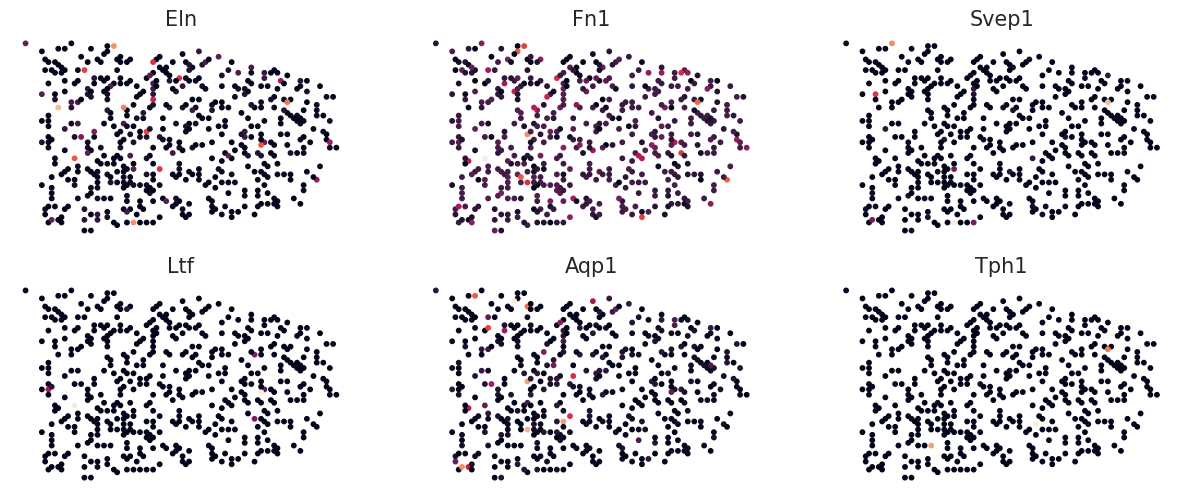

<Figure size 432x288 with 0 Axes>

In [148]:
# TNBC
# pl_genes = ['Eln', 'Fn1', 'Svep1', 'Ltf', 'Aqp1', 'Tph1']

# Mouse



# create
dataset_tissue = sc.AnnData(pd.DataFrame(tissue.sdge.T, columns = gene_names), dtype=float)
dataset_tissue.obsm['spatial'] = locations
novosparc.pl.embedding(dataset_tissue, pl_genes)